# Inverse Kinematics (2D)

In [1]:
%matplotlib notebook
from matplotlib import pylab as plt
from numpy import sin, cos, pi, matrix, random, linalg, asarray
from scipy.linalg import pinv
from __future__ import division
from math import atan2
from IPython import display
from ipywidgets import interact, fixed

## Coordinate Transformation

In [2]:
def trans(x, y, a):
    '''create a 2D transformation'''
    s = sin(a)
    c = cos(a)
    return matrix([[c, -s, x],
                   [s,  c, y],
                   [0,  0, 1]])

def from_trans(m):
    '''get x, y, theta from transform matrix'''
    return [m[0, -1], m[1, -1], atan2(m[1, 0], m[0, 0])]

In [3]:
trans(0, 0, 0)

matrix([[ 1., -0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]])

## Parameters of robot arm

In [4]:
l = [0, 3, 2, 1]
#l = [0, 3, 2, 1, 1]
#l = [0, 3, 2, 1, 1, 1]
#l = [1] * 30
N = len(l) - 1  # number of links
max_len = sum(l)
a = random.random_sample(N)  # angles of joints
T0 = trans(0, 0, 0)  # base

## Forward Kinematics

In [5]:
def forward_kinematics(T0, l, a):
    T = [T0]
    for i in range(len(a)):
        Ti = T[-1] * trans(l[i], 0, a[i])
        T.append(Ti)
    Te = T[-1] * trans(l[-1], 0, 0)  # end effector
    T.append(Te)
    return T

In [6]:
def show_robot_arm(T):
    plt.cla()
    x = [Ti[0,-1] for Ti in T]
    y = [Ti[1,-1] for Ti in T]
    plt.plot(x, y, '-or', linewidth=5, markersize=10)
    plt.plot(x[-1], y[-1], 'og', linewidth=5, markersize=10)
    plt.xlim([-max_len, max_len])
    plt.ylim([-max_len, max_len]) 
    ax = plt.axes()
    ax.set_aspect('equal')
    t = atan2(T[-1][1, 0], T[-1][0,0])
    ax.annotate('[%.2f,%.2f,%.2f]' % (x[-1], y[-1], t), xy=(x[-1], y[-1]), xytext=(x[-1], y[-1] + 0.5))
    plt.show()
    return ax

## Inverse Kinematics

### Numerical Solution with Jacobian

NOTE: while numerical inverse kinematics is easy to implemente, two issues have to be keep in mind:
* stablility: the correction step (lambda_) has to be small, but it will take longer time to converage
* singularity: there are singularity poses (all 0, for example), the correction will be 0, so the algorithm won't work. That's why many robots bends its leg when walking

<IPython.core.display.Javascript object>


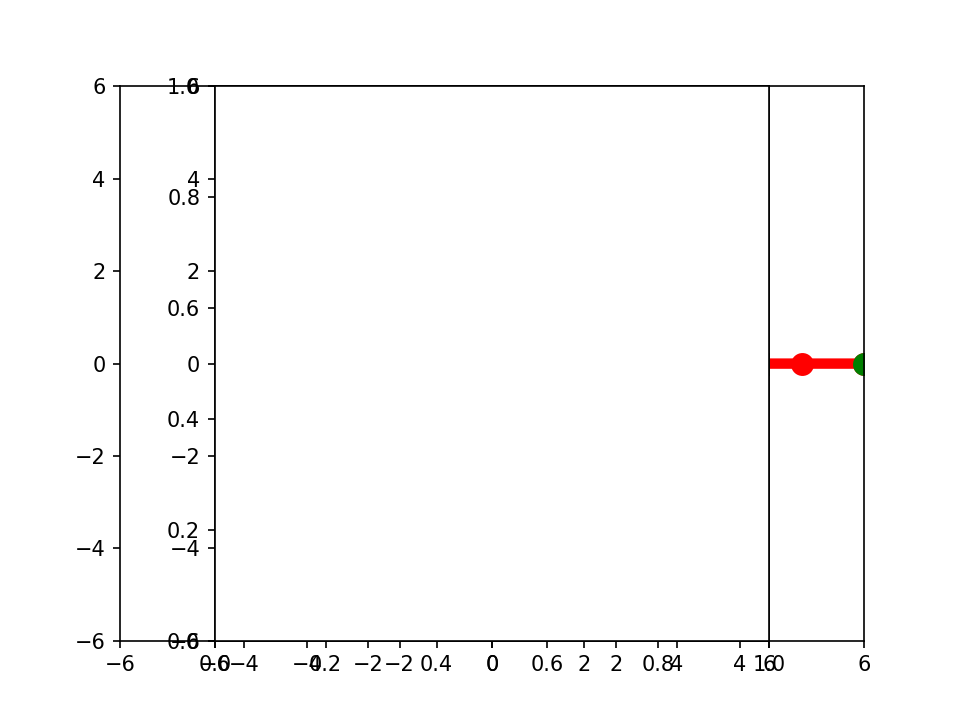

interactive(children=(FloatSlider(value=5.999999999636367, description='x_e', max=6.0, step=0.01), FloatSlider…

interactive(children=(FloatSlider(value=5.999999999636367, description='x_e', max=6.0, step=0.01), FloatSlider…

In [7]:
theta = random.random(N) * 1e-5
lambda_ = 1
max_step = 0.1
def inverse_kinematics(x_e, y_e, theta_e, theta):
    target = matrix([[x_e, y_e, theta_e]]).T
    for i in range(1000):
        Ts = forward_kinematics(T0, l, theta)
        Te = matrix([from_trans(Ts[-1])]).T
        e = target - Te
        e[e > max_step] = max_step
        e[e < -max_step] = -max_step
        T = matrix([from_trans(i) for i in Ts[1:-1]]).T
        J = Te - T
        dT = Te - T
        J[0, :] = -dT[1, :] # x
        J[1, :] = dT[0, :] # y
        J[-1, :] = 1  # angular
        d_theta = lambda_ * pinv(J) * e
        theta += asarray(d_theta.T)[0]
        if  linalg.norm(d_theta) < 1e-4:
            break
    return theta

T = forward_kinematics(T0, l, theta)
show_robot_arm(T)
Te = matrix([from_trans(T[-1])])

@interact(x_e=(0, max_len, 0.01), y_e=(-max_len, max_len, 0.01), theta_e=(-pi, pi, 0.01), theta=fixed(theta))
def set_end_effector(x_e=Te[0,0], y_e=Te[0,1], theta_e=Te[0,2], theta=theta):
    theta = inverse_kinematics(x_e, y_e, theta_e, theta)
    T = forward_kinematics(T0, l, theta)
    show_robot_arm(T)
    return theta